## DATA PREPARATION AND CLEANING

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
#importing only important varibles
import os
import pandas as pd
pd.options.mode.chained_assignment =  'warn'
os.chdir("/Users/edhungel/Documents/Research/UNCC/ukbiobank/eliza/raw_data")
metadata = pd.read_csv("ukb50043.csv", usecols = ["eid","46-0.0", "47-0.0", "816-0.0",  "6150-0.0", "21000-0.0",  "22001-0.0" ])
metadata.columns = ["eid", "grip_strength_left", "grip_strength_right","job_category",  "vascular_problem_category",  "Ethnicity","genetic_sex"]

#working on british population ony

metadata = metadata[metadata["Ethnicity"]==1001.0] ##British
metadata.shape



(442519, 7)

Text(3, 3226, '3216')

Text(4, 2367, '2357')

Text(5, 2324, '2314')

Text(6, 2321, '2311')

Text(7, 2321, '2311')

Text(8, 2321, '2311')

Text(9, 2321, '2311')

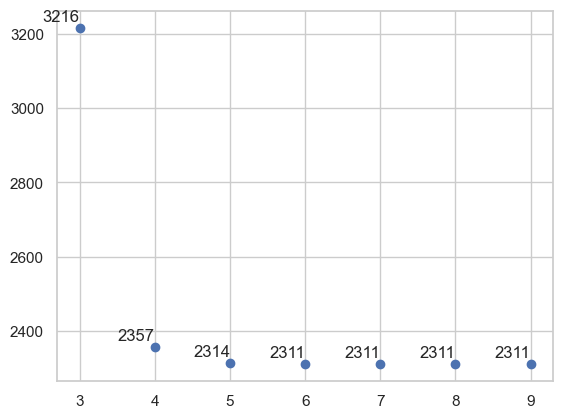

In [36]:
#Outlier detection
#mean-3*(sigma) or above mean+3*(sigma) 
import numpy as np
mean=np.mean(metadata["grip_strength_right"])
sigma=np.std(metadata["grip_strength_right"])

falsevaluecount=[]
for val in range(3,10):
    lowerlimit=mean-val*(sigma)
    upperlimit=mean+val*(sigma) 
    falsevaluecount.append(((metadata["grip_strength_right"] > lowerlimit) & (metadata["grip_strength_right"] < upperlimit)).value_counts()[0]) #False vlaue count
import matplotlib.pyplot as plt
plt.scatter(y=falsevaluecount, x=list(range(3,10)))
for i, txt in enumerate(falsevaluecount):
    plt.text(list(range(3,10))[i], falsevaluecount[i]+10, str(txt), ha='right', va='bottom')
    

In [38]:
#Cleaning the data
metadata_clean=metadata.loc[(metadata["job_category"] > 0) & 
                            (metadata["grip_strength_right"].notna())  &
                            (metadata["vascular_problem_category"] != -3 )          & 
                            (metadata["grip_strength_right"] > (mean-6*(sigma)) )  &
                            (metadata["grip_strength_right"] <  (mean+6*(sigma)))  ,: ]
metadata.shape

metadata_clean.shape

442519-249033

(442519, 7)

(249033, 7)

193486

In [39]:
(metadata_clean["genetic_sex"]).value_counts()
125230/249033

0.0    125230
1.0    117666
Name: genetic_sex, dtype: int64

0.5028650821377086

In [27]:

summary_table = metadata_clean.groupby(["genetic_sex", "job_category", "vascular_problem_category"]).agg(
    sample_size=pd.NamedAgg(column="grip_strength_right", aggfunc="size"),  
    mean_grip_strength=pd.NamedAgg(column="grip_strength_right", aggfunc="mean"),
    median_grip_strength=pd.NamedAgg(column="grip_strength_right", aggfunc="median"),
    std_grip_strength=pd.NamedAgg(column="grip_strength_right", aggfunc="std")
).reset_index()

summary_table.to_csv("/Users/edhungel/Documents/PhD_UNCC/spring_2024/advanced_stats/hand_grip_strength/summar_stats.txt")

## TWO WAY ANOVA TO SEE IF THERE IS DIFFERENCE IN MEAN OF THE GRIP STRENGTH BETWEEN MALE AND FEMALE AND THOSE WHO REPORT DIFFERENT LEVEL OF MANUAL WORK

**ASSUMPTIONS**

- Normality : meets based on central limit theorem
- independence : meets based on the design of expriment
- homogenity of variance : anova is robust till the variance ratio is 4

In [7]:
#Lets arrange the data for analysis
dict_of_male_data={}
dict_of_female_data={}
for val in range(1,5):
        female_data = metadata_clean.loc[metadata_clean["genetic_sex"]==0.0,]
        dict_of_female_data[val] = female_data[female_data["job_category"]== val]
        male_data = metadata_clean.loc[metadata_clean["genetic_sex"]==1.0,]
        dict_of_male_data[val] = male_data[male_data["job_category"]== val]
    

In [8]:
#levene test for equality of variance
#NULL null hypothesis that all input samples are from populations with equal variances.
from scipy.stats import levene
levene(dict_of_male_data[1]["grip_strength_right"],dict_of_male_data[2]["grip_strength_right"],dict_of_male_data[3]["grip_strength_right"],dict_of_male_data[4]["grip_strength_right"],
      dict_of_female_data[1]["grip_strength_right"],dict_of_female_data[2]["grip_strength_right"],dict_of_female_data[3]["grip_strength_right"],dict_of_female_data[4]["grip_strength_right"])




LeveneResult(statistic=1660.0727413670454, pvalue=0.0)

In [9]:
import statistics as stats
from itertools import chain
list_to_find_varaince= [dict_of_male_data[1]["grip_strength_right"],dict_of_male_data[2]["grip_strength_right"],dict_of_male_data[3]["grip_strength_right"],dict_of_male_data[4]["grip_strength_right"],
      dict_of_female_data[1]["grip_strength_right"],dict_of_female_data[2]["grip_strength_right"],dict_of_female_data[3]["grip_strength_right"],dict_of_female_data[4]["grip_strength_right"]]

varlist = []
for var in list_to_find_varaince:
    varlist.append(stats.variance(var))


varainceratio = []
for idx,val in enumerate(varlist):
    varainceratio.append([ var /varlist[idx] for var in varlist])
flattened_list = list(chain(*varainceratio))


count_VarRatioMorethan4= 0
for val in flattened_list:
    if val >= 4:
        count_VarRatioMorethan4=count_VarRatioMorethan4+1
print(count_VarRatioMorethan4)

count_VarRatioMorethan2= 0
for val in flattened_list:
    if val >= 2:
        count_VarRatioMorethan2=count_VarRatioMorethan2+1
print(count_VarRatioMorethan2)


0
7


**7 variance ratio is greater than 2, but none are greater than 4**

As anova is robust till the variance is more than 4, the assumption of equality of variance will not effect the analysis much.

In [10]:
#Lets decode the data so that factor level are string rather than numeric
d_sex = {
        0.0 : "female", 
        1.0 : "male" 
        }
d_job_category = {
    1.0: "Never/rarely",
    2.0:"Sometimes",
    3.0:"Usually",
    4.0:"Always"    
}
d_vascular_problem_category = {
    1.0: "Heart attack",
    2.0: "Angina",
    3.0:"Stroke",
    4.0:"High blood pressure",
    -7.0 : "None of the above"
}

In [11]:
#DO NOT RUN MORE THAN ONCE
import pandas as pd
pd.options.mode.chained_assignment =  None
# Example DataFrame

metadata_clean['genetic_sex'] = metadata_clean['genetic_sex'].map(d_sex)
metadata_clean['job_category'] = metadata_clean['job_category'].map(d_job_category)
metadata_clean['vascular_problem_category'] = metadata_clean['vascular_problem_category'].map(d_vascular_problem_category)



In [12]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
from statsmodels.formula.api import ols 

model = ols('grip_strength_right~ C(job_category) + C(genetic_sex) + C(job_category):C(genetic_sex)', data = metadata_clean).fit()
anova_res=sm.stats.anova_lm(model, typ=2)

anova_res


,sum_sq,df,F,PR(>F)
C(job_category),5.332529e+03,3.0,29.718373,3.353442e-19
C(genetic_sex),1.610953e+07,1.0,269336.929271,0.000000e+00
C(job_category):C(genetic_sex),4.888555e+03,3.0,27.244088,1.313210e-17
Residual,1.452757e+07,242888.0,NaN,NaN


In [13]:
#[male_1_4, female_1_4]
meanitems = []
for items in list_to_find_varaince:
    meanitems.append(np.mean(items))
meanitems


[42.1458424895442,
 42.73633392192959,
 42.665227403569375,
 42.02536662703131,
 25.91991273123949,
 25.863379496975487,
 25.835326438267614,
 25.43062605752961]

<AxesSubplot:xlabel='job_category', ylabel='grip_strength_right'>

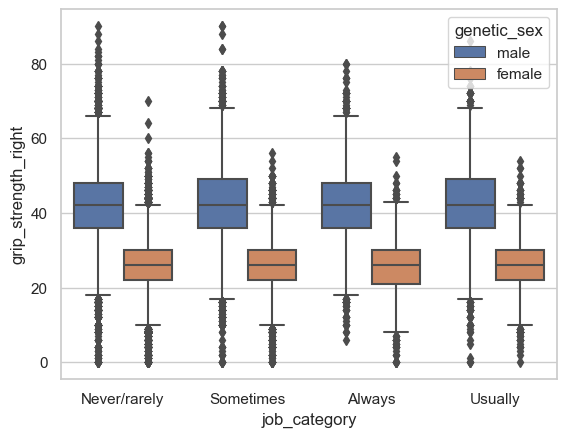

In [14]:
import seaborn as sns
sns.set(style='whitegrid')
sns.boxplot(y= metadata_clean["grip_strength_right"], x = metadata_clean["job_category"], hue= metadata_clean["genetic_sex"])

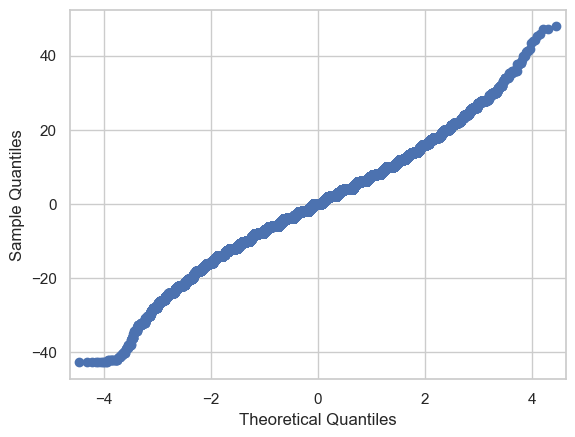

In [15]:
res = model.resid 
fig = sm.qqplot(res)#, stats.t)#, fit=True, line="45")
plt.show()

In [32]:
from scipy.stats import tukey_hsd

p_values_pergroup_fe =tukey_hsd(dict_of_male_data[1]["grip_strength_right"],dict_of_male_data[2]["grip_strength_right"],dict_of_male_data[3]["grip_strength_right"],dict_of_male_data[4]["grip_strength_right"],
      dict_of_female_data[1]["grip_strength_right"],dict_of_female_data[2]["grip_strength_right"],dict_of_female_data[3]["grip_strength_right"],dict_of_female_data[4]["grip_strength_right"])

print(p_values_pergroup_fe)

#, p_adjust = 'holm')
#p_values_pergroup_fe


Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.590     0.000    -0.759    -0.422
 (0 - 2)     -0.519     0.000    -0.765    -0.273
 (0 - 3)      0.120     0.827    -0.129     0.370
 (0 - 4)     16.226     0.000    16.107    16.344
 (0 - 5)     16.282     0.000    16.110    16.455
 (0 - 6)     16.311     0.000    16.000    16.621
 (0 - 7)     16.715     0.000    16.398    17.033
 (1 - 0)      0.590     0.000     0.422     0.759
 (1 - 2)      0.071     0.993    -0.200     0.342
 (1 - 3)      0.711     0.000     0.437     0.985
 (1 - 4)     16.816     0.000    16.652    16.980
 (1 - 5)     16.873     0.000    16.667    17.079
 (1 - 6)     16.901     0.000    16.570    17.232
 (1 - 7)     17.306     0.000    16.969    17.643
 (2 - 0)      0.519     0.000     0.273     0.765
 (2 - 1)     -0.071     0.993    -0.342     0.200
 (2 - 3)      0.640     0.000     0.313     0.967
 (2 - 4)     16.745     0.000   

## CHISQUARE TEST
Chi-square test of independence: 
- Does the medical condition of people, blood pressure, have agnia, healthy, other disease etc depend on the level of maual work reported for job?

In [17]:
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests

#Adopted from https://neuhofmo.github.io/chi-square-and-post-hoc-in-python/

def get_asterisks_for_pval(p_val):

    """Receives the p-value and returns asterisks string."""
    if p_val > 0.05:
        p_text = "ns"  # above threshold => not significant
    elif p_val < 1e-4:  
        p_text = '****'
    elif p_val < 1e-3:
        p_text = '***'
    elif p_val < 1e-2:
        p_text = '**'
    else:
        p_text = '*'
    
    return p_text

def chisq_and_posthoc_corrected(df):
    listoflist=[]
    """Receives a dataframe and performs chi2 test and then post hoc.
    Prints the p-values and corrected p-values (after FDR correction)"""
    # start by running chi2 test on the matrix
    chi2, p, dof, ex = chi2_contingency(df, correction=True)
    print(f"Chi2 result of the contingency table: {chi2}, p-value: {p}")
    
    # post-hoc
    all_combinations = list(combinations(df.index, 2))  # gathering all combinations for post-hoc chi2
    p_vals = []
    print("Significance results:")
    for comb in all_combinations:
        new_df = df[(df.index == comb[0]) | (df.index == comb[1])]
        chi2, p, dof, ex = chi2_contingency(new_df, correction=True)
        p_vals.append(p)
        # print(f"For {comb}: {p}")  # uncorrected

    # checking significance
    # correction for multiple testing
    reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
    for p_val, corr_p_val, reject, comb in zip(p_vals, corrected_p_vals, reject_list, all_combinations):
        print(f"{comb}: p_value: {p_val:5f}; corrected: {corr_p_val:5f} ({get_asterisks_for_pval(p_val)}) reject: {reject}")
        listoflist.append([ comb, p_val,corr_p_val, reject])
    df = pd.DataFrame(listoflist, columns = ["comparision" , "p_value", "corrected_p_value", "reject"])   
    return(df)

        


In [18]:
#Overall
from scipy.stats import chi2_contingency
crosstablejobcat_vasular_disease = pd.crosstab(metadata_clean["job_category"],metadata_clean["vascular_problem_category"])
crosstablejobcat_vasular_disease
overall_res=chisq_and_posthoc_corrected(crosstablejobcat_vasular_disease)

#Male
crosstablejobcat_vasular_disease_male = pd.crosstab(male_data["job_category"],male_data["vascular_problem_category"])
crosstablejobcat_vasular_disease_male
male_res=chisq_and_posthoc_corrected(crosstablejobcat_vasular_disease_male)

#Female
crosstablejobcat_vasular_disease_female = pd.crosstab(female_data["job_category"],female_data["vascular_problem_category"])
crosstablejobcat_vasular_disease_female
female_res =chisq_and_posthoc_corrected(crosstablejobcat_vasular_disease_female)


vascular_problem_category,Angina,Heart attack,High blood pressure,None of the above,Stroke
job_category,,,,,
Always,214,272,3382,12421,110
Never/rarely,1496,1754,30924,127449,980
Sometimes,685,791,10991,40164,415
Usually,232,267,3451,12920,114


Chi2 result of the contingency table: 325.42574760484206, p-value: 2.118818236614393e-62
Significance results:
('Always', 'Never/rarely'): p_value: 0.000000; corrected: 0.000000 (****) reject: True
('Always', 'Sometimes'): p_value: 0.350514; corrected: 0.421902 (ns) reject: False
('Always', 'Usually'): p_value: 0.891739; corrected: 0.891739 (ns) reject: False
('Never/rarely', 'Sometimes'): p_value: 0.000000; corrected: 0.000000 (****) reject: True
('Never/rarely', 'Usually'): p_value: 0.000000; corrected: 0.000000 (****) reject: True
('Sometimes', 'Usually'): p_value: 0.351585; corrected: 0.421902 (ns) reject: False


vascular_problem_category,-7.0,1.0,2.0,3.0,4.0
job_category,,,,,
1.0,52078,1458,1035,540,15424
2.0,18987,674,487,251,6218
3.0,7619,239,177,79,2308
4.0,7415,225,161,77,2214


Chi2 result of the contingency table: 81.1936751218586, p-value: 2.4421206549001986e-12
Significance results:
(1.0, 2.0): p_value: 0.000000; corrected: 0.000000 (****) reject: True
(1.0, 3.0): p_value: 0.169133; corrected: 0.253699 (ns) reject: False
(1.0, 4.0): p_value: 0.687017; corrected: 0.824421 (ns) reject: False
(2.0, 3.0): p_value: 0.009438; corrected: 0.018876 (**) reject: True
(2.0, 4.0): p_value: 0.000869; corrected: 0.002608 (***) reject: True
(3.0, 4.0): p_value: 0.960910; corrected: 0.960910 (ns) reject: False


vascular_problem_category,-7.0,1.0,2.0,3.0,4.0
job_category,,,,,
1.0,72215,267,436,417,14668
2.0,20202,98,181,153,4494
3.0,5003,21,49,32,1083
4.0,4719,39,46,32,1074


Chi2 result of the contingency table: 91.08690500765972, p-value: 3.0404072808850035e-14
Significance results:
(1.0, 2.0): p_value: 0.000000; corrected: 0.000000 (****) reject: True
(1.0, 3.0): p_value: 0.008053; corrected: 0.016105 (**) reject: True
(1.0, 4.0): p_value: 0.000000; corrected: 0.000000 (****) reject: True
(2.0, 3.0): p_value: 0.749698; corrected: 0.749698 (ns) reject: False
(2.0, 4.0): p_value: 0.064111; corrected: 0.096166 (ns) reject: False
(3.0, 4.0): p_value: 0.114191; corrected: 0.137029 (ns) reject: False


In [19]:
overall_res
male_res
male_res

,comparision,p_value,corrected_p_value,reject
0,"(Always, Never/rarely)",4.075047e-21,1.222514e-20,True
1,"(Always, Sometimes)",3.505135e-01,4.219024e-01,False
2,"(Always, Usually)",8.917391e-01,8.917391e-01,False
3,"(Never/rarely, Sometimes)",3.110238e-48,1.866143e-47,True
4,"(Never/rarely, Usually)",1.126957e-18,2.253914e-18,True
5,"(Sometimes, Usually)",3.515854e-01,4.219024e-01,False


,comparision,p_value,corrected_p_value,reject
0,"(1.0, 2.0)",3.496903e-16,2.098142e-15,True
1,"(1.0, 3.0)",1.691328e-01,2.536991e-01,False
2,"(1.0, 4.0)",6.870171e-01,8.244206e-01,False
3,"(2.0, 3.0)",9.437763e-03,1.887553e-02,True
4,"(2.0, 4.0)",8.692165e-04,2.607650e-03,True
5,"(3.0, 4.0)",9.609098e-01,9.609098e-01,False


,comparision,p_value,corrected_p_value,reject
0,"(1.0, 2.0)",3.496903e-16,2.098142e-15,True
1,"(1.0, 3.0)",1.691328e-01,2.536991e-01,False
2,"(1.0, 4.0)",6.870171e-01,8.244206e-01,False
3,"(2.0, 3.0)",9.437763e-03,1.887553e-02,True
4,"(2.0, 4.0)",8.692165e-04,2.607650e-03,True
5,"(3.0, 4.0)",9.609098e-01,9.609098e-01,False


## PAIRED T TEST TO SEE DIFFERENCE IN LEFT HAND VS RIGHT HAND

In [20]:
(metadata_clean["grip_strength_left"]).isna().value_counts()

False    248696
True        337
Name: grip_strength_left, dtype: int64

In [21]:
metadata_clean2 = metadata_clean[metadata_clean["grip_strength_left"].notna()]
metadata_clean.shape
metadata_clean2.shape

(249033, 7)

(248696, 7)

In [23]:
import scipy.stats as scpystats
55985 + 93
#NULL:  variance of grip strength in left and right hand is same..
    
levene(metadata_clean2["grip_strength_left"],metadata_clean2["grip_strength_right"]) #cant reject the null hypothesis
np.var(metadata_clean2["grip_strength_left"])/np.var(metadata_clean2["grip_strength_right"])
scpystats.ttest_rel(metadata_clean2["grip_strength_left"],metadata_clean2["grip_strength_right"], alternative='two-sided') 

56078

LeveneResult(statistic=6.66182281848747, pvalue=0.009850294509621157)

1.0115713283008188

TtestResult(statistic=-217.06697329383843, pvalue=0.0, df=248695)

In [24]:
scpystats.ttest_rel(metadata_clean2["grip_strength_left"],metadata_clean2["grip_strength_right"], alternative='less') 

TtestResult(statistic=-217.06697329383843, pvalue=0.0, df=248695)

## REGRESSION HAND GRIP STRENGTH AND DISEASE CATEGORY

In [26]:
import os
os.getcwd()

'/Users/edhungel/Documents/Research/UNCC/ukbiobank/eliza/raw_data'

this is printing and plotting


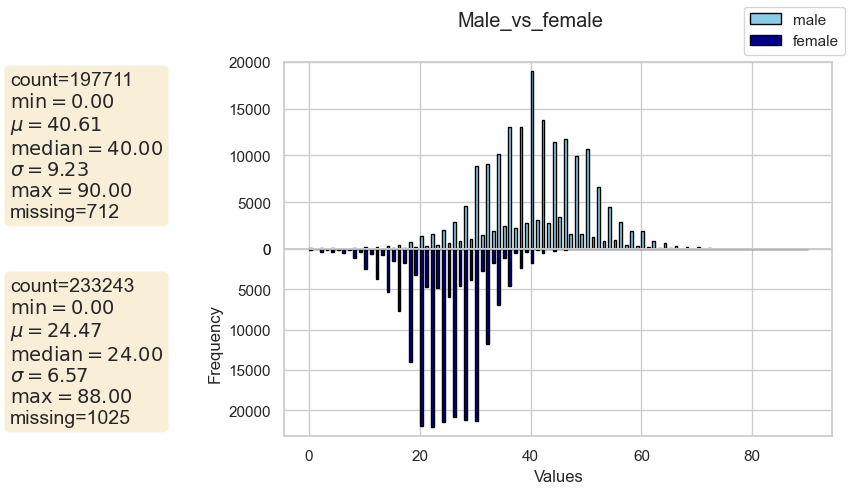

In [40]:
def getsummarystats( single_metabolite, tp_value = None, lfc = None) :

        mu1 = single_metabolite.mean()
        median1 = np.nanmedian(single_metabolite)
        sigma1 = single_metabolite.std()
        minval1 = min(single_metabolite)
        maxval1 = max(single_metabolite)
        count1 = len(single_metabolite)
        missing1 = sum(single_metabolite.isnull())
        if tp_value is None:
            textstr1 = '\n'.join((
                    r'count=' + "" +str(count1),
                    r'$\min=%.2f$' % (minval1, ),
                    r'$\mu=%.2f$' % (mu1, ),
                    r'$\mathrm{median}=%.2f$' % (median1, ),
                    r'$\sigma=%.2f$' % (sigma1, ),
                    r'$\max=%.2f$' % (maxval1, ),
                    r'missing=' + "" +str(missing1, )))
        else:
            textstr1 = '\n'.join((
                    r'count=' + "" +str(count1),
                    r'$\min=%.2f$' % (minval1, ),
                    r'$\mu=%.2f$' % (mu1, ),
                    r'$\mathrm{median}=%.2f$' % (median1, ),
                    r'$\sigma=%.2f$' % (sigma1, ),
                    r'$\max=%.2f$' % (maxval1, ),
                    r'missing=' + "" +str(missing1, ),
                    r'pvalue=' + str("{:.3e}".format(tp_value)),
                    r'$\logfoldchange=%.4f$' % (lfc, ) ) )
        return textstr1



def draw_histogram(  data1, data2, textstr1, textstr2, bins,metabolite_nametotitle):

        graph, (plot1, plot2) = plt.subplots(2, 1)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        graph.suptitle( metabolite_nametotitle )

        plot1.hist(data1, bins = bins, color= 'skyblue', edgecolor='black')
        plot1.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
        plot2.hist(data2, bins=bins, color='darkblue', edgecolor='black')
        plot2.invert_yaxis()
        graph.legend([ "male", "female"],  loc='upper right')
        graph.tight_layout()
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.subplots_adjust(hspace=0)
        print("this is printing and plotting")
        plot1.text(-0.5, 0.95, textstr1, transform=plot1.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        plot2.text(-0.5, 0.85, textstr2, transform=plot2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
import matplotlib.pyplot as plt
import numpy as np
metadata_sub = metadata[metadata["Ethnicity"]==1001.0] ##British
male_data = metadata["grip_strength_right"][metadata["genetic_sex"]== 1.0]
female_data = metadata["grip_strength_right"][metadata["genetic_sex"]== 0.0]
textstr1 = getsummarystats(male_data) #self.ttest_p_value_all[indexval] ,self.alllogfoldchange[indexval]  )
textstr2 = getsummarystats( female_data )#, ttest_pvalue)

bins=np.arange(min(  min(male_data) ,min( female_data ) ),   max(  max(male_data) ,max( female_data ) ) + 0.5, 0.5)
draw_histogram(male_data , female_data , textstr1, textstr2, bins, "Male_vs_female")
